In [10]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input


In [4]:
BASE_DIR = 'dataset'
train_dir = os.path.join(BASE_DIR, 'train')
valid_dir = os.path.join(BASE_DIR, 'validation')
test_dir = os.path.join(BASE_DIR, 'test')


## EDA

Jumlah gambar train:
Jumlah gambar kelas 'CORROSION' di 'dataset\train': 693
Jumlah gambar kelas 'NOCORROSION' di 'dataset\train': 580

Jumlah gambar validation:
Jumlah gambar kelas 'CORROSION' di 'dataset\validation': 198
Jumlah gambar kelas 'NOCORROSION' di 'dataset\validation': 166

Jumlah gambar test:
Jumlah gambar kelas 'CORROSION' di 'dataset\test': 99
Jumlah gambar kelas 'NOCORROSION' di 'dataset\test': 83


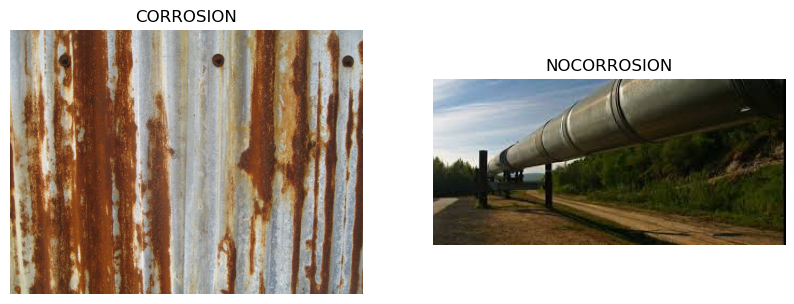

In [7]:
def count_images(directory):
    classes = os.listdir(directory)
    for cls in classes:
        cls_path = os.path.join(directory, cls)
        print(f"Jumlah gambar kelas '{cls}' di '{directory}': {len(os.listdir(cls_path))}")

print("Jumlah gambar train:")
count_images(train_dir)
print("\nJumlah gambar validation:")
count_images(valid_dir)
print("\nJumlah gambar test:")
count_images(test_dir)

def is_image_file(filename):
    valid_ext = ['.jpg','.jpeg','.png','.bmp']
    ext = os.path.splitext(filename)[1].lower()
    return ext in valid_ext

plt.figure(figsize=(10,5))
for i, cls in enumerate(os.listdir(train_dir)):
    plt.subplot(1, 2, i+1)
    class_path = os.path.join(train_dir, cls)
    valid_images = [f for f in os.listdir(class_path) if is_image_file(f)]
    sample_img_path = os.path.join(class_path, valid_images[0])
    img = plt.imread(sample_img_path)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.show()


## PRE PROCESS

In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1273 images belonging to 2 classes.
Found 364 images belonging to 2 classes.
Found 182 images belonging to 2 classes.


In [9]:
def build_resnet50_model(input_shape=(224,224,3)):
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_resnet50_model()
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,  # beri kesempatan max 50 epoch
    callbacks=[early_stop]
)


c:\Users\CAKRA CIPUTRA\miniconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 106s 3s/step - accuracy: 0.7328 - loss: 0.5162 - val_accuracy: 0.9093 - val_loss: 0.2450
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9366 - loss: 0.2041 - val_accuracy: 0.9176 - val_loss: 0.1931
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9510 - loss: 0.1401 - val_accuracy: 0.9368 - val_loss: 0.1695
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9729 - loss: 0.1052 - val_accuracy: 0.9258 - val_loss: 0.1959
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.9672 - loss: 0.1012 - val_accuracy: 0.9396 - val_loss: 0.1443
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.9793 - loss: 0.0845 - val_accuracy: 0.9533 - val_loss: 0.1400
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9708 - loss: 0.0844 - val_accuracy: 0.9451 - val_loss: 0.1356
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.9814 - loss: 0.0628 - val_accuracy: 0.9451 - val_loss

In [12]:
model.save('model_resnet50_corrosion.keras')


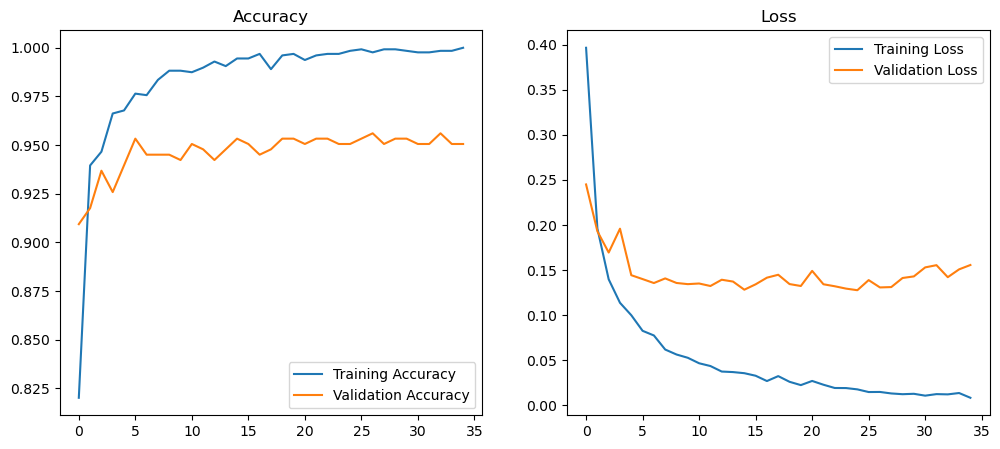

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step
Classification Report:
              precision    recall  f1-score   support

   CORROSION       0.94      0.98      0.96        99
 NOCORROSION       0.97      0.93      0.95        83

    accuracy                           0.96       182
   macro avg       0.96      0.95      0.96       182
weighted avg       0.96      0.96      0.96       182



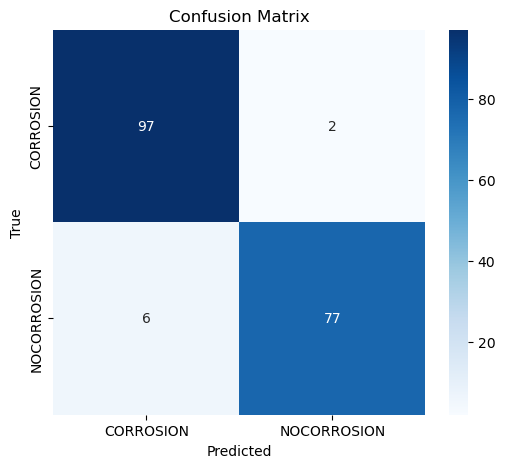

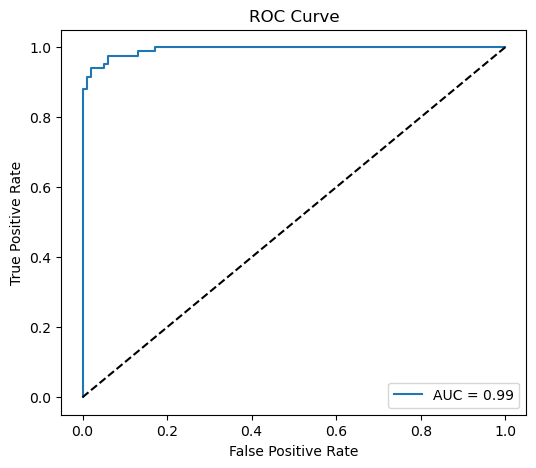

In [14]:
# Prediksi probabilitas dan kelas pada data test
y_prob = model.predict(test_generator).flatten()
y_pred = (y_prob >= 0.5).astype(int)
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve dan AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc = roc_auc_score(y_true, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()